In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
train_df = pd.read_csv("datasets/dataset_train.csv")

In [3]:
train_df.head(3)

Index Hogwarts House First Name Last Name    Birthday Best Hand  \
0      0      Ravenclaw     Tamara       Hsu  2000-03-30      Left   
1      1      Slytherin      Erich   Paredes  1999-10-14     Right   
2      2      Ravenclaw   Stephany     Braun  1999-11-03      Left   

   Arithmancy   Astronomy  Herbology  Defense Against the Dark Arts  \
0     58384.0 -487.886086   5.727180                       4.878861   
1     67239.0 -552.060507  -5.987446                       5.520605   
2     23702.0 -366.076117   7.725017                       3.660761   

   Divination  Muggle Studies  Ancient Runes  History of Magic  \
0       4.722      272.035831     532.484226          5.231058   
1      -5.612     -487.340557     367.760303          4.107170   
2       6.140      664.893521     602.585284          3.555579   

   Transfiguration   Potions  Care of Magical Creatures     Charms  Flying  
0      1039.788281  3.790369                   0.715939 -232.79405  -26.89  
1      1058.944592  7.248742                   0.091674 -252.18425 -113.45  
2      1088.088348  8.728531                  -0.515327 -227.34265   30.42

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          1600 non-null   int64  
 1   Hogwarts House                 1600 non-null   object 
 2   First Name                     1600 non-null   object 
 3   Last Name                      1600 non-null   object 
 4   Birthday                       1600 non-null   object 
 5   Best Hand                      1600 non-null   object 
 6   Arithmancy                     1566 non-null   float64
 7   Astronomy                      1568 non-null   float64
 8   Herbology                      1567 non-null   float64
 9   Defense Against the Dark Arts  1569 non-null   float64
 10  Divination                     1561 non-null   float64
 11  Muggle Studies                 1565 non-null   float64
 12  Ancient Runes                  1565 non-null   f

In [5]:
train_df["Hogwarts House"].value_counts()

Hogwarts House
Hufflepuff    529
Ravenclaw     443
Gryffindor    327
Slytherin     301
Name: count, dtype: int64

### Visualization Utils

In [6]:
def plot_categorical_pie(
    data,
    column_name,
    hue=None,
    hole=0,
    figsize=(6,6),
    palette='Set2',
    title=None
):
    """
    Plot pie (or donut) chart(s) of a categorical variable, optionally faceted by a hue column,
    and annotate each pie with the corresponding hue value.
    Always sorts categories by name.

    Parameters
    ----------
    data : pandas.DataFrame
        Input data.
    column_name : str
        Name of the categorical variable to plot.
    hue : str or None
        Column name to facet by (e.g. 'TARGET'). If None, only one pie is drawn.
    hole : float, default=0
        Fraction of radius to cut out of the center (0 = full pie, up to <1).
    figsize : tuple, default=(6,6)
        Matplotlib figure size. If hue is given, width is multiplied by #groups.
    palette : seaborn palette name or list of colors
    title : str or None
        Overall title. If None, defaults to column_name (or "{column_name} by {hue}").

    Returns
    -------
    fig, axes : matplotlib Figure and Axes (or array of Axes)
    """
    # Determine grouping
    if hue is None:
        groups = [None]
    else:
        groups = sorted(data[hue].dropna().unique())
    
    n = len(groups)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]),
                             squeeze=False)
    axes = axes[0]
    
    # Shared palette
    if isinstance(palette, str):
        palette = sns.color_palette(palette)
    
    for ax, grp in zip(axes, groups):
        if grp is None:
            subset = data
            suptitle = title or f'Distribution of {column_name}'
            hue_text = ''
        else:
            subset = data[data[hue] == grp]
            suptitle = title or f'Distribution of {column_name} | {hue} = {grp}'
            hue_text = f'{hue} = {grp}'
        
        counts = subset[column_name].value_counts()
        counts = counts.sort_index()
        labels = counts.index.astype(str)
        sizes  = counts.values
        
        # pick colors cycling through palette
        colors = palette * math.ceil(len(labels)/len(palette))
        colors = colors[:len(labels)]
        
        pie_kwargs = dict(
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors
        )
        if hole > 0:
            pie_kwargs['wedgeprops'] = dict(width=1-hole)
        
        wedges, texts, autotexts = ax.pie(sizes, **pie_kwargs)
        ax.axis('equal')
        ax.set_title(suptitle, pad=20)
        
        # annotate hue value in center for donut
        if hole > 0 and hue is not None:
            ax.text(0, 0, hue_text,
                    ha='center', va='center',
                    fontsize=12, fontweight='bold')
    
    plt.tight_layout()




def plot_continuous_distribution(
    data,
    column_name,
    hue=None,
    plots=['distplot', 'CDF', 'box', 'violin'],
    scale_limits=None,
    figsize=(20, 8),
    histogram=True,
    log_scale=False
):
    """
    Plot continuous variable distributions using Seaborn and Matplotlib.

    Parameters
    ----------
    data : pandas.DataFrame
        The DataFrame containing the data.
    column_name : str
        Name of the continuous column to plot.
    hue : str or None
        Column name for grouping (e.g., 'TARGET'). If None, no grouping.
    plots : list of str
        Which plots to include: 'distplot', 'CDF', 'box', 'violin'.
    scale_limits : tuple (low, high) or None
        Range to trim outliers; defaults to 1st–99th percentiles.
    figsize : tuple
        Figure size.
    histogram : bool
        Whether to overlay histogram on distplot.
    log_scale : bool
        Whether to set y-axis to log scale for all plots.
    """
    # Determine bounds
    col = data[column_name].dropna()
    if scale_limits:
        lower, upper = scale_limits
    else:
        lower = np.percentile(col, 1)
        upper = np.percentile(col, 99)
    df = data[(data[column_name] >= lower) & (data[column_name] <= upper)]

    n_plots = len(plots)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, squeeze=False)
    axes = axes[0]

    for ax, plot_type in zip(axes, plots):
        if plot_type == 'distplot':
            if histogram:
                sns.histplot(
                    data=df,
                    x=column_name,
                    hue=hue,
                    kde=True,
                    ax=ax
                )
            else:
                sns.kdeplot(
                    data=df,
                    x=column_name,
                    hue=hue,
                    ax=ax
                )
            ax.set_title('Density & Histogram')

        elif plot_type == 'CDF':
            if hue:
                for grp, grp_df in df.groupby(hue):
                    x = np.sort(grp_df[column_name].dropna())
                    y = np.arange(len(x)) / (len(x) - 1)
                    ax.plot(x, y, label=f'{hue}={grp}')
                ax.legend()
            else:
                x = np.sort(df[column_name].dropna())
                y = np.arange(len(x)) / (len(x) - 1)
                ax.plot(x, y)
            ax.set_xlabel(column_name)
            ax.set_ylabel('CDF')
            ax.set_title('Cumulative Distribution')

        elif plot_type == 'box':
            if hue:
                sns.boxplot(x=hue, y=column_name, data=df, ax=ax)
            else:
                sns.boxplot(y=column_name, data=df, ax=ax)
            ax.set_title('Boxplot')

        elif plot_type == 'violin':
            if hue:
                sns.violinplot(x=hue, y=column_name, data=df, ax=ax)
            else:
                sns.violinplot(y=column_name, data=df, ax=ax)
            ax.set_title('Violin Plot')

        if log_scale:
            ax.set_yscale('log')

    fig.suptitle(f'Distributions for {column_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Target Variable

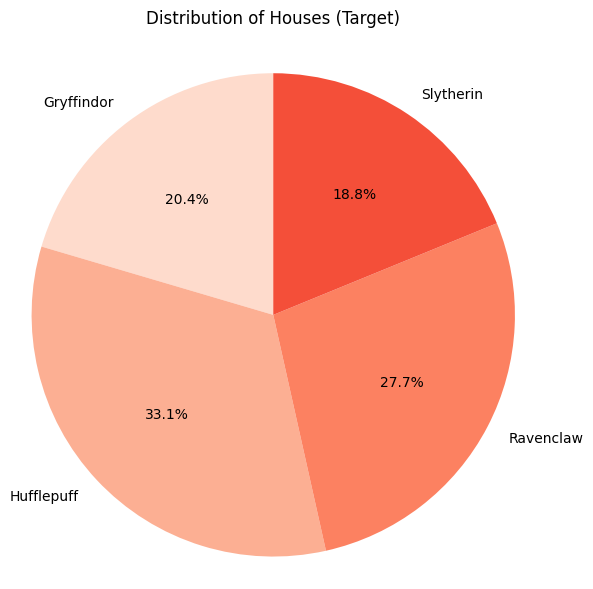

In [7]:
plot_categorical_pie(train_df, "Hogwarts House", title="Distribution of Houses (Target)", palette="Reds")

## Predictiors

This section aims to discover patterns in predictors across different houses.
This information may give us insights into how to **model probability of student assigned to some House**

### Best Hand (Not interesting)

**Nothing interesting here... Best Hands are distributed evenly for all houses.**

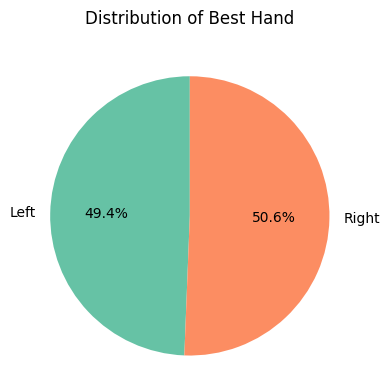

In [8]:
plot_categorical_pie(train_df, "Best Hand", figsize=(4, 4))

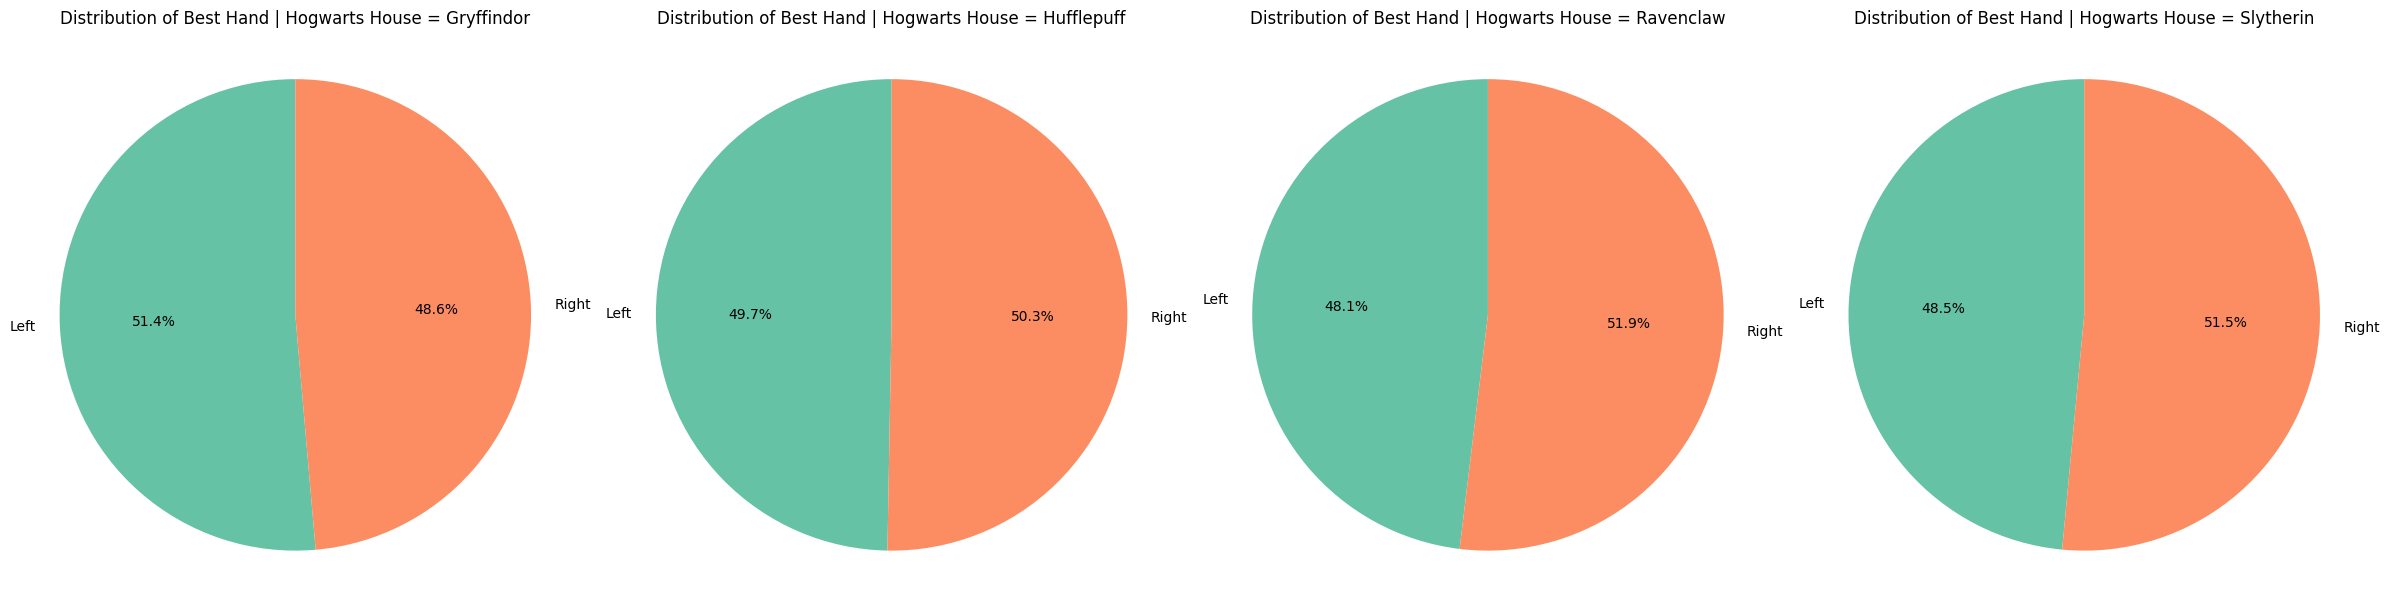

In [9]:
plot_categorical_pie(train_df, "Best Hand", hue="Hogwarts House")

### Year of Birth (Not interesting)

In [10]:
train_df['Year of Birth'] = pd.to_datetime(train_df["Birthday"]).dt.year #for simplicity, take only Year of Birth


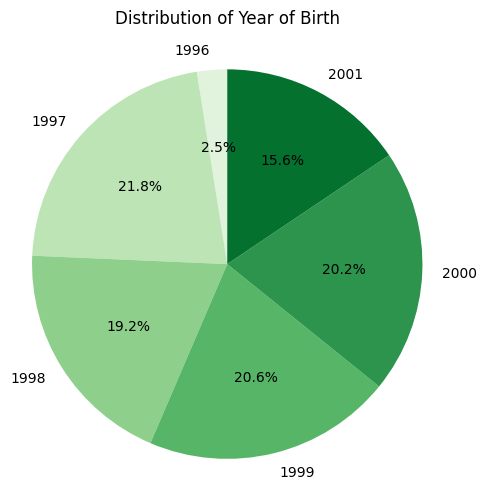

In [11]:
plot_categorical_pie(train_df, "Year of Birth", figsize=(5, 5), palette="Greens")

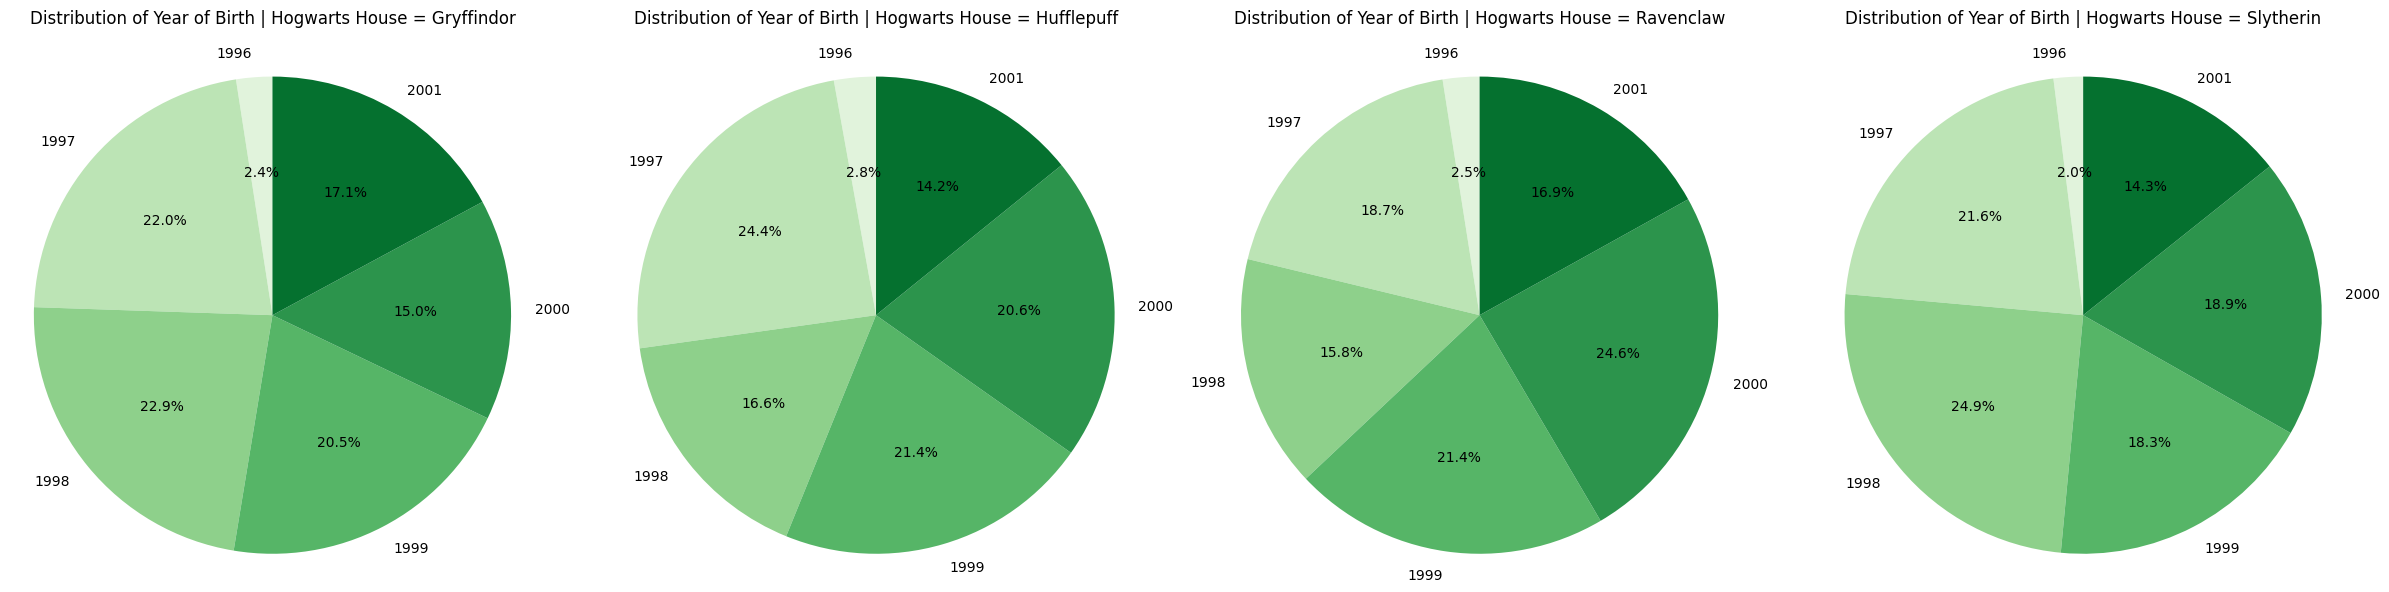

In [12]:
plot_categorical_pie(train_df.sort_values("Year of Birth"), "Year of Birth", hue="Hogwarts House",  palette="Greens")

**Year of Birth seems like uninformative variable that does not vary much across Houses**

### Arithmancy (Not interesting)

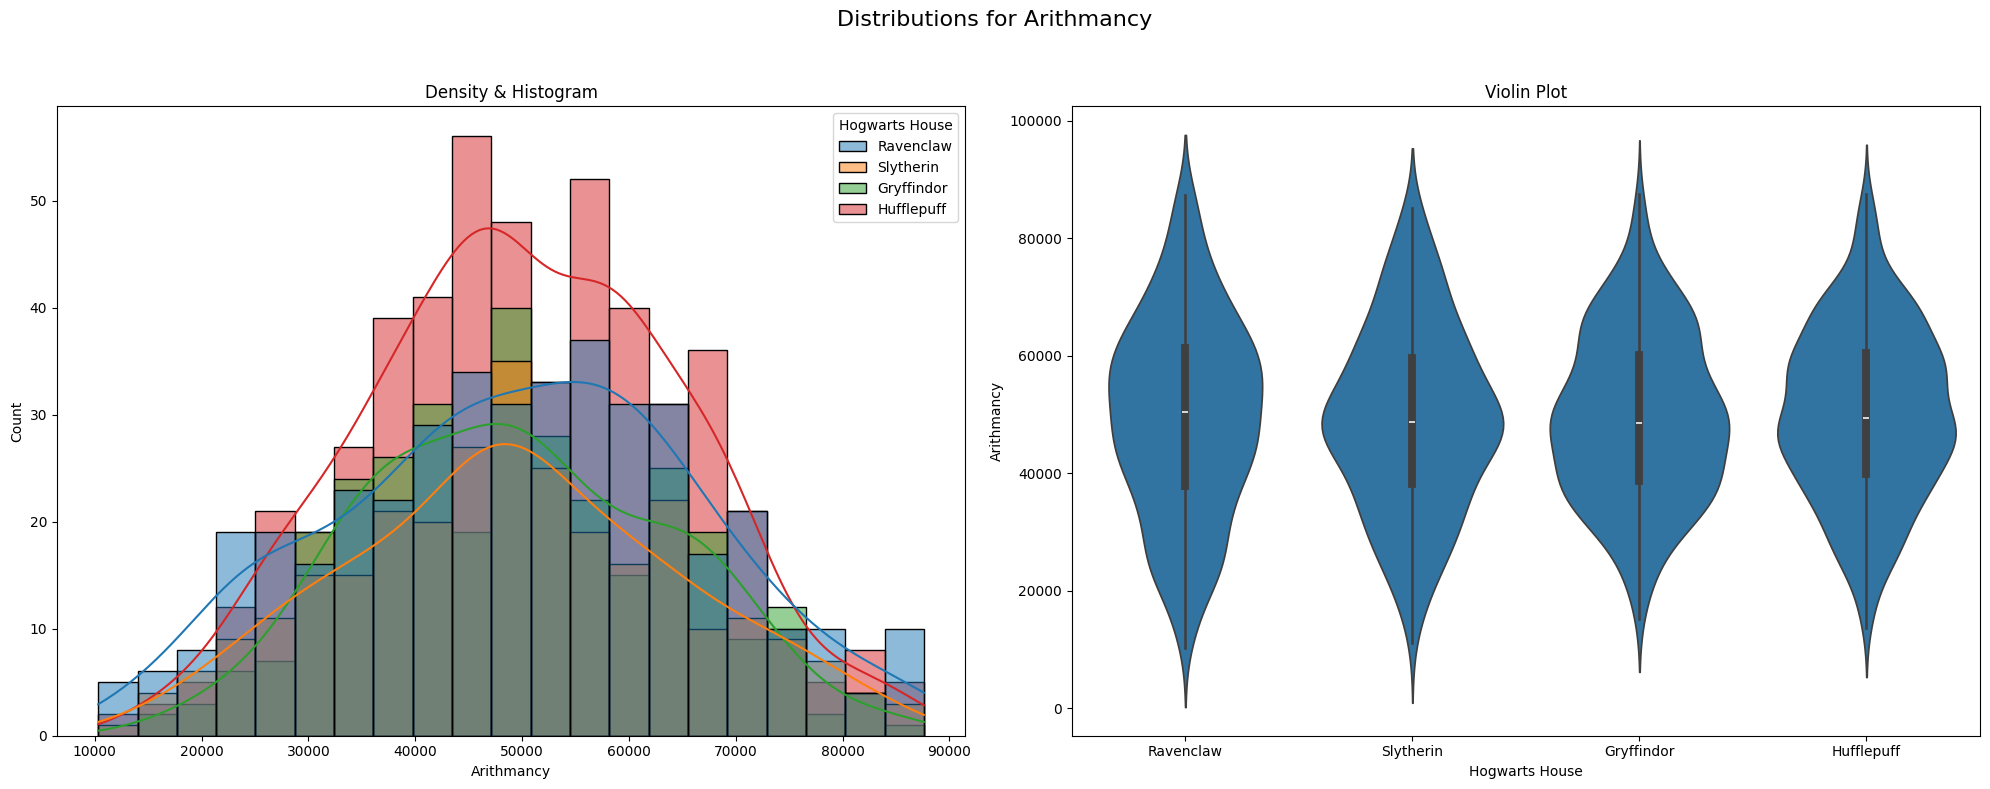

In [13]:
plot_continuous_distribution(train_df, "Arithmancy",hue="Hogwarts House", plots=["distplot", "violin"])

### Astronomy (Interesting)

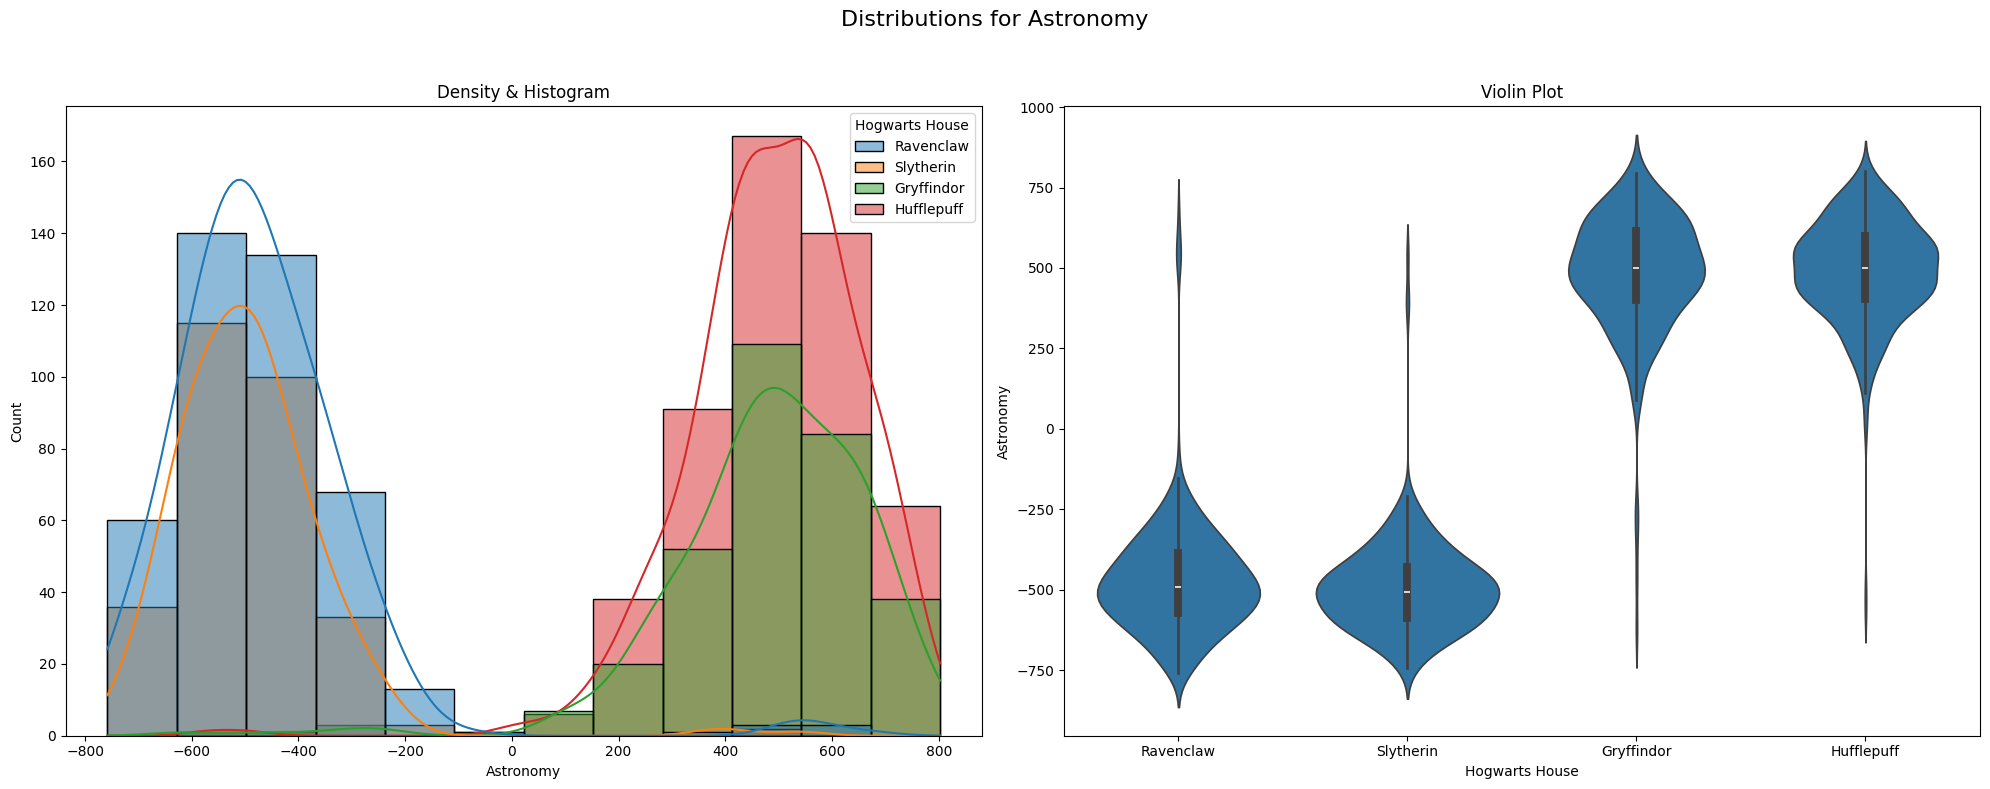

In [14]:
plot_continuous_distribution(train_df, "Astronomy",hue="Hogwarts House", plots=["distplot", "violin"])

In [15]:
train_df.head()

Index Hogwarts House First Name  Last Name    Birthday Best Hand  \
0      0      Ravenclaw     Tamara        Hsu  2000-03-30      Left   
1      1      Slytherin      Erich    Paredes  1999-10-14     Right   
2      2      Ravenclaw   Stephany      Braun  1999-11-03      Left   
3      3     Gryffindor      Vesta  Mcmichael  2000-08-19      Left   
4      4     Gryffindor     Gaston      Gibbs  1998-09-27      Left   

   Arithmancy   Astronomy  Herbology  Defense Against the Dark Arts  \
0     58384.0 -487.886086   5.727180                       4.878861   
1     67239.0 -552.060507  -5.987446                       5.520605   
2     23702.0 -366.076117   7.725017                       3.660761   
3     32667.0  697.742809  -6.497214                      -6.977428   
4     60158.0  436.775204  -7.820623                            NaN   

   Divination  Muggle Studies  Ancient Runes  History of Magic  \
0       4.722      272.035831     532.484226          5.231058   
1      -5.612     -487.340557     367.760303          4.107170   
2       6.140      664.893521     602.585284          3.555579   
3       4.026     -537.001128     523.982133         -4.809637   
4       2.236     -444.262537     599.324514         -3.444377   

   Transfiguration   Potions  Care of Magical Creatures     Charms  Flying  \
0      1039.788281  3.790369                   0.715939 -232.79405  -26.89   
1      1058.944592  7.248742                   0.091674 -252.18425 -113.45   
2      1088.088348  8.728531                  -0.515327 -227.34265   30.42   
3       920.391449  0.821911                  -0.014040 -256.84675  200.64   
4       937.434724  4.311066                  -0.264070 -256.38730  157.98   

   Year of Birth  
0           2000  
1           1999  
2           1999  
3           2000  
4           1998

### Herbology (Interesting)


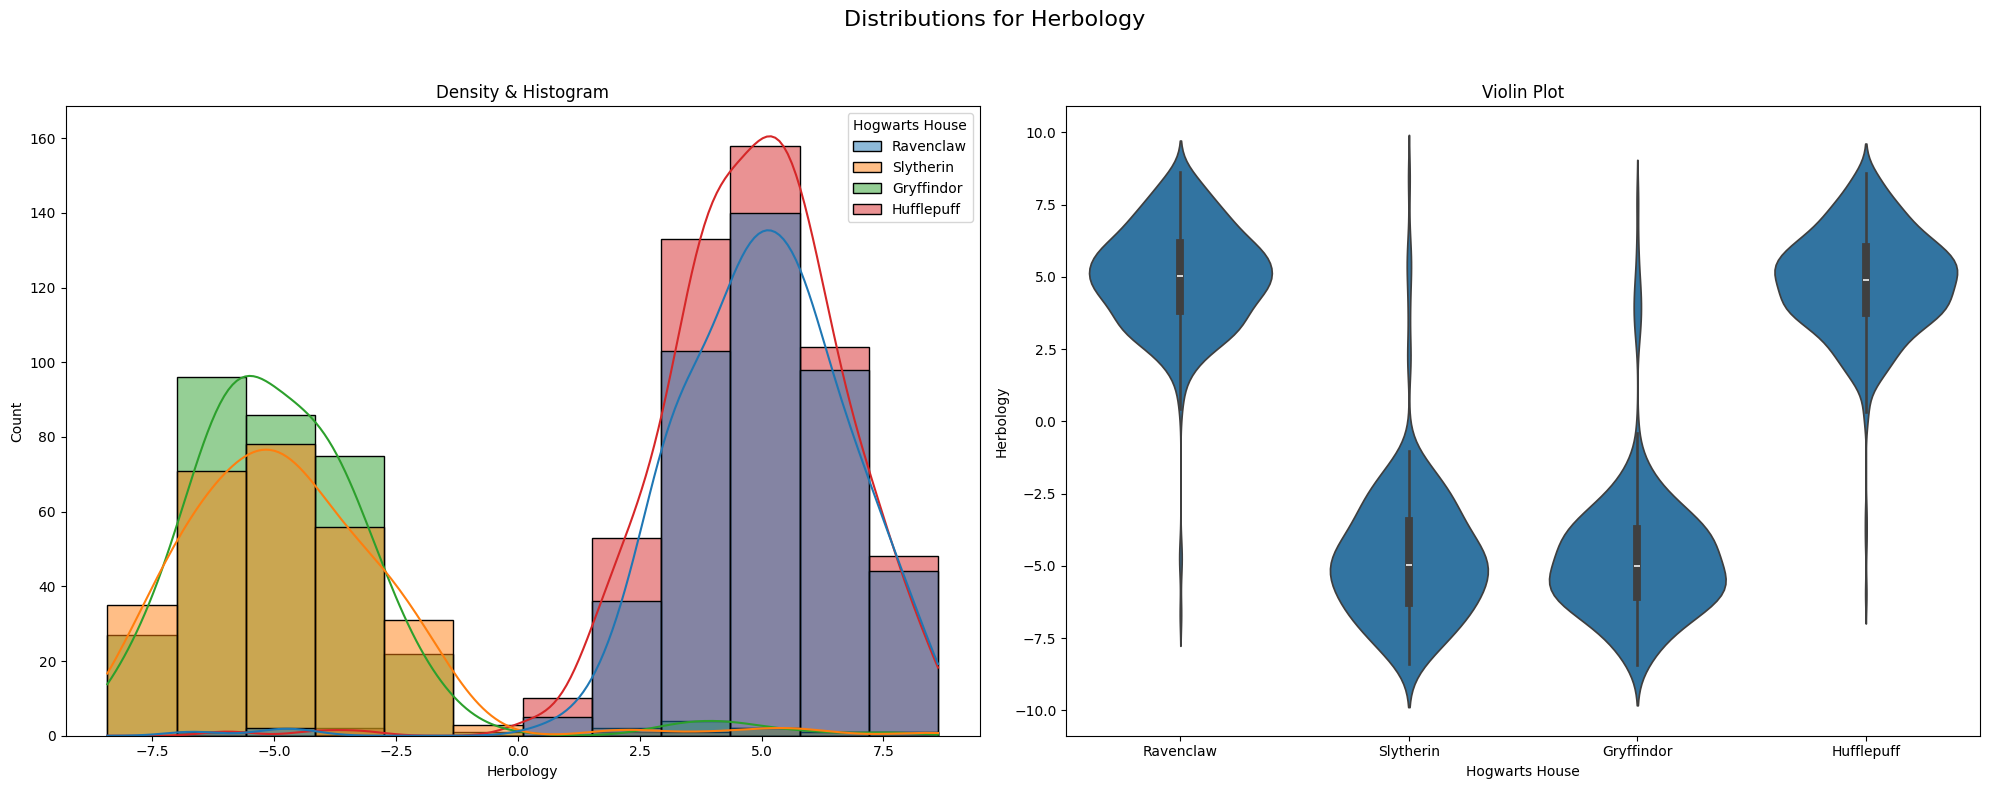

In [16]:
plot_continuous_distribution(train_df, "Herbology",hue="Hogwarts House", plots=["distplot", "violin"])

### Defense Against the Dark Arts (Interesting)

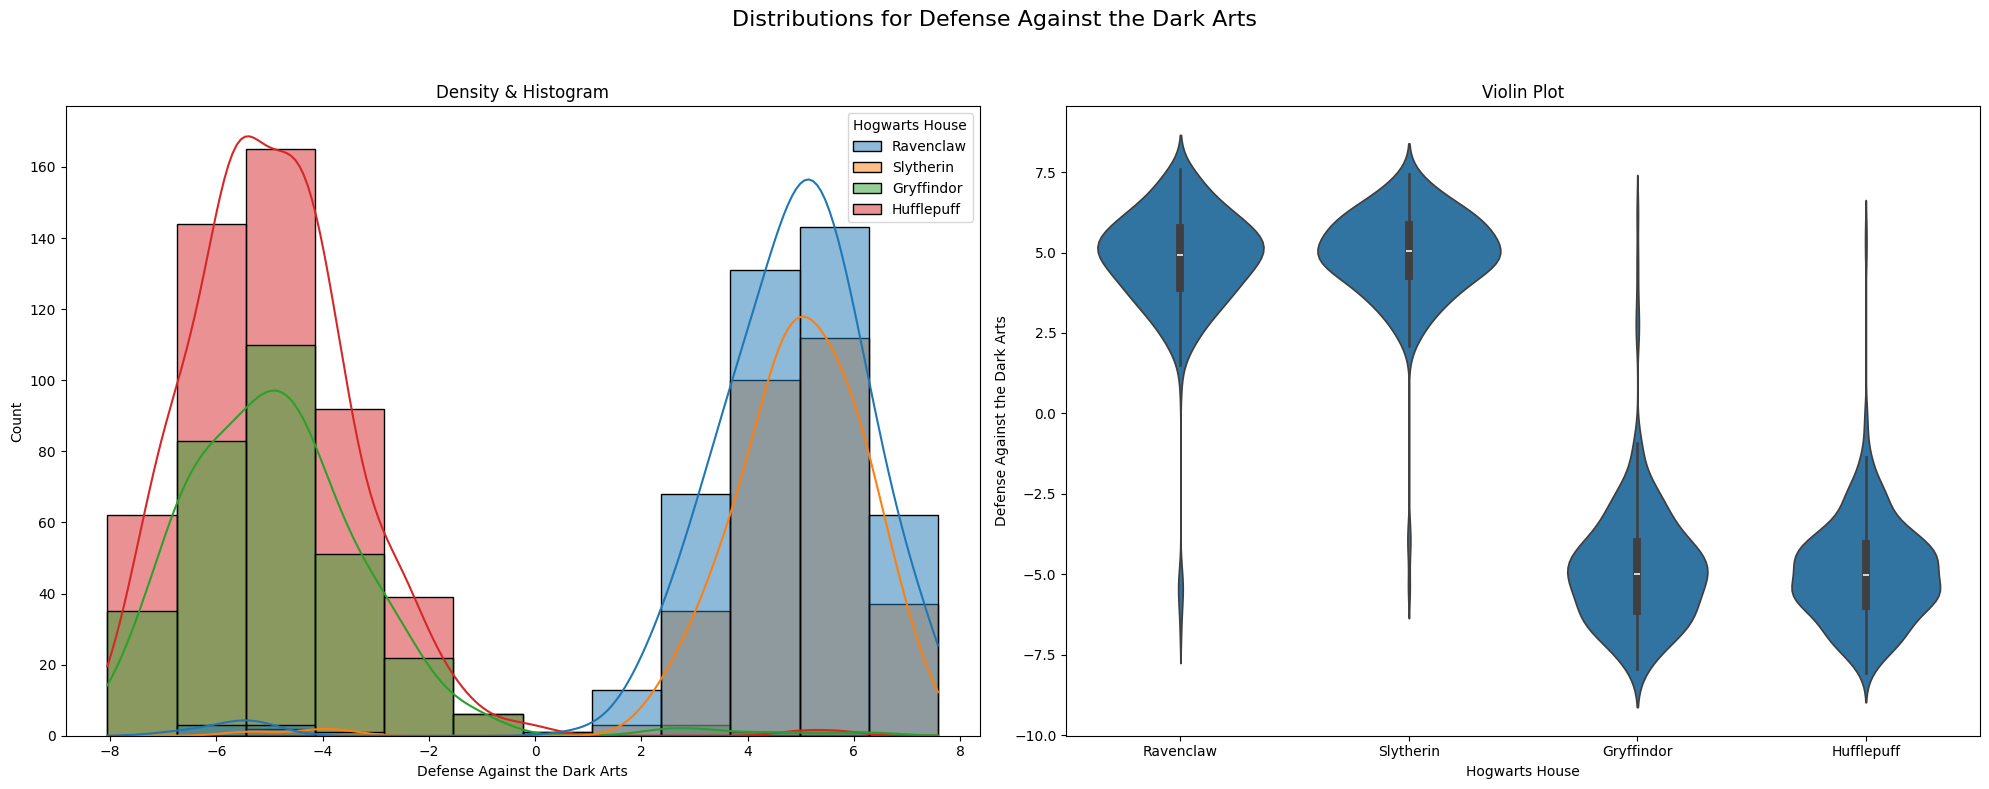

In [17]:
plot_continuous_distribution(train_df, "Defense Against the Dark Arts",hue="Hogwarts House", plots=["distplot", "violin"])

### Divination (Very Interesting)

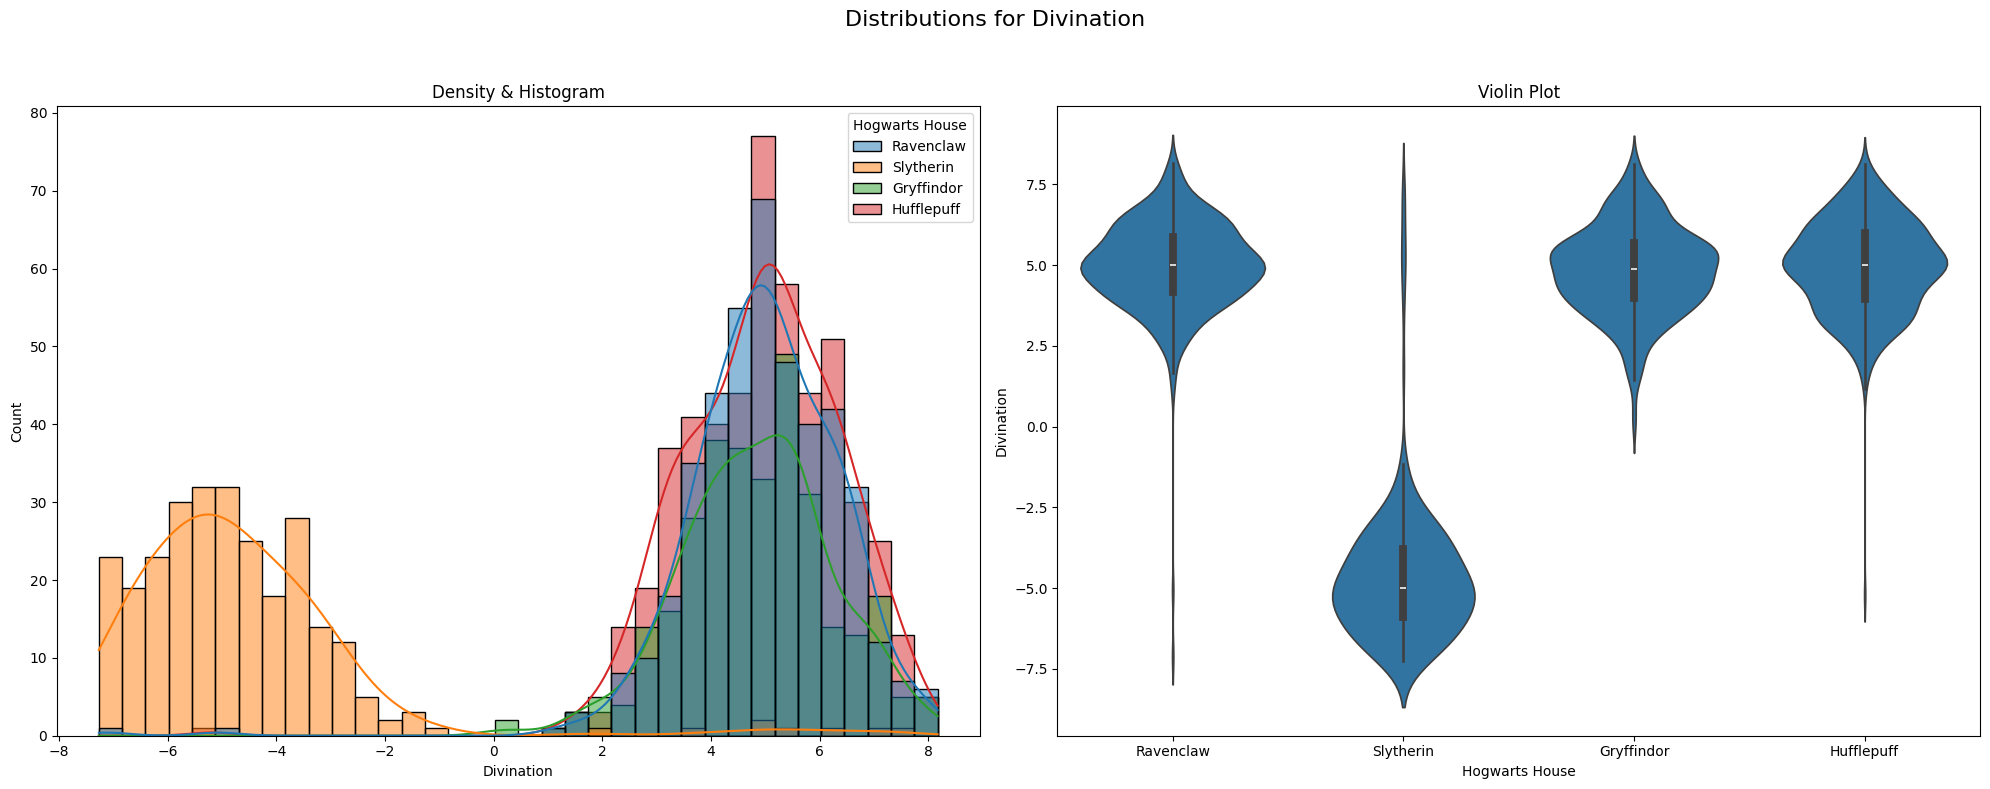

In [18]:
plot_continuous_distribution(train_df, "Divination",hue="Hogwarts House", plots=["distplot", "violin"])

### Muggle Studies (Very Interesting)

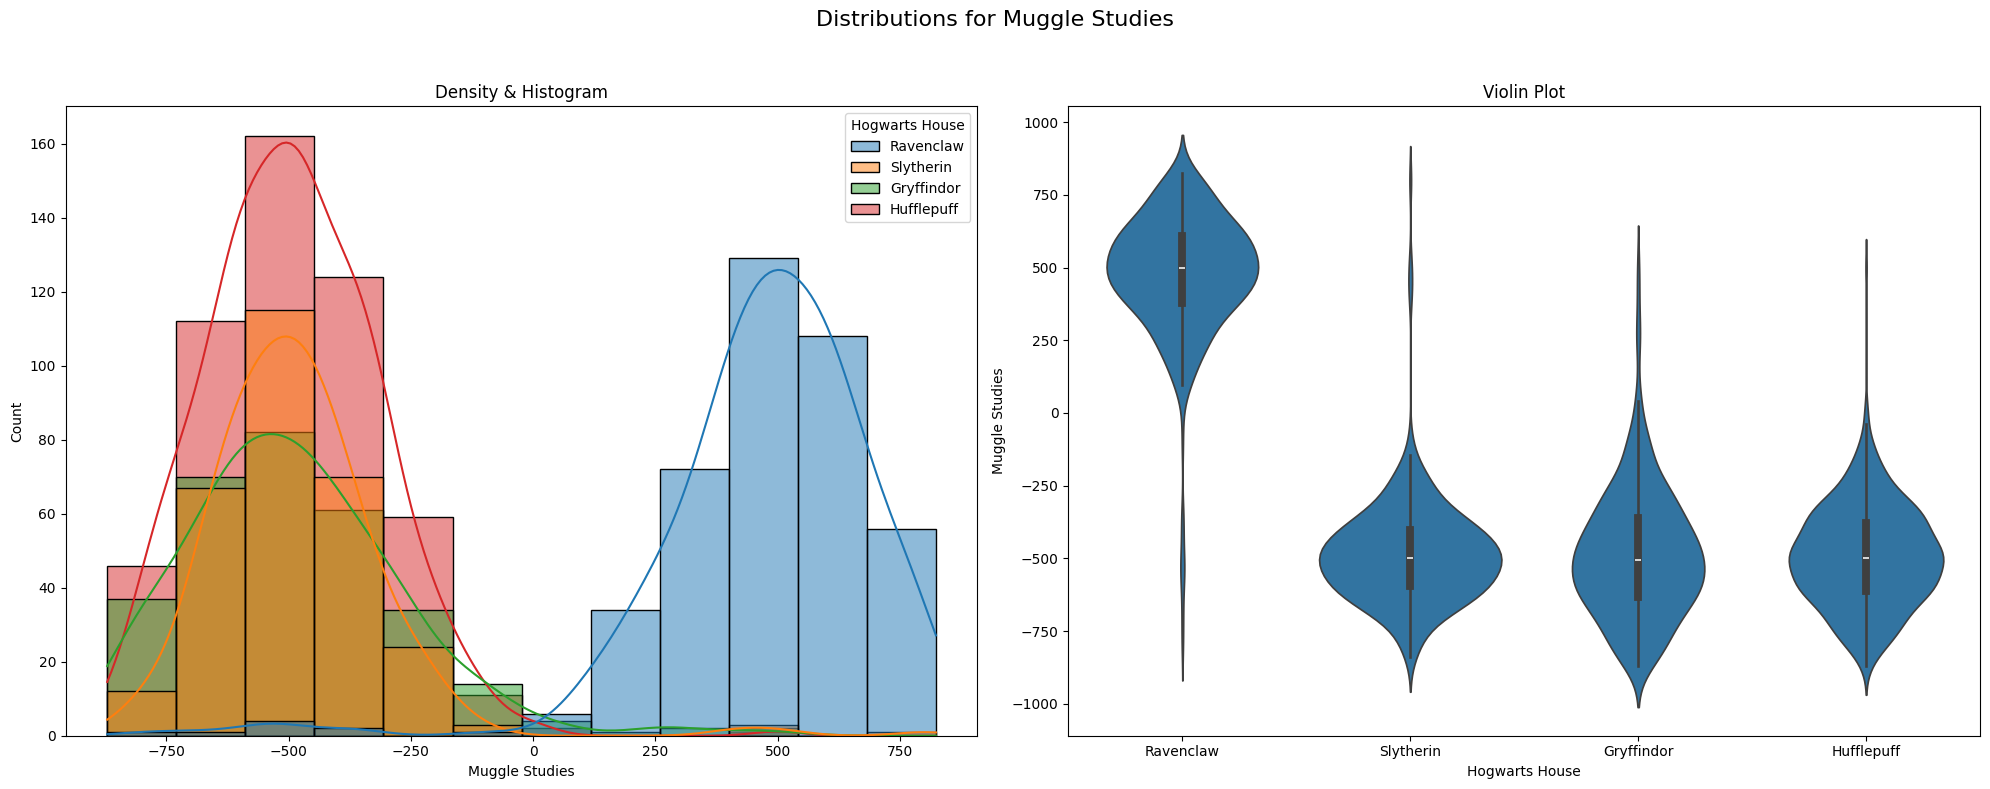

In [19]:
plot_continuous_distribution(train_df, "Muggle Studies",hue="Hogwarts House", plots=["distplot", "violin"])

### Ancient Runes (Interesting)

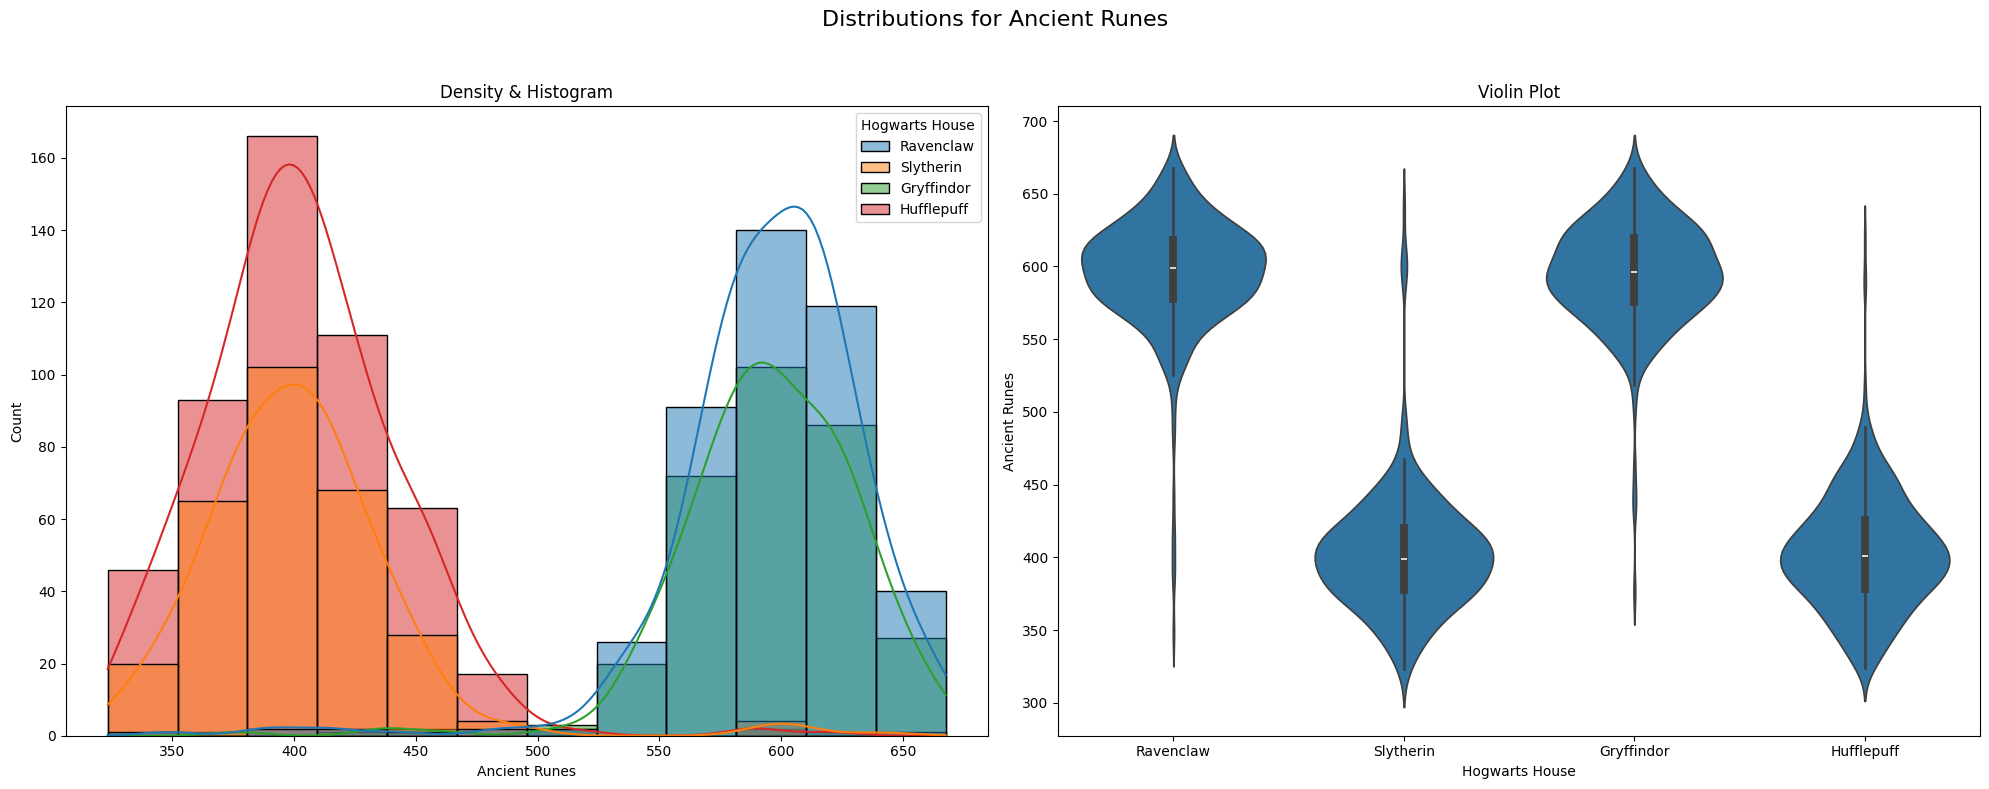

In [20]:
plot_continuous_distribution(train_df, "Ancient Runes",hue="Hogwarts House", plots=["distplot", "violin"])

### History of Magic (Very Interesting)

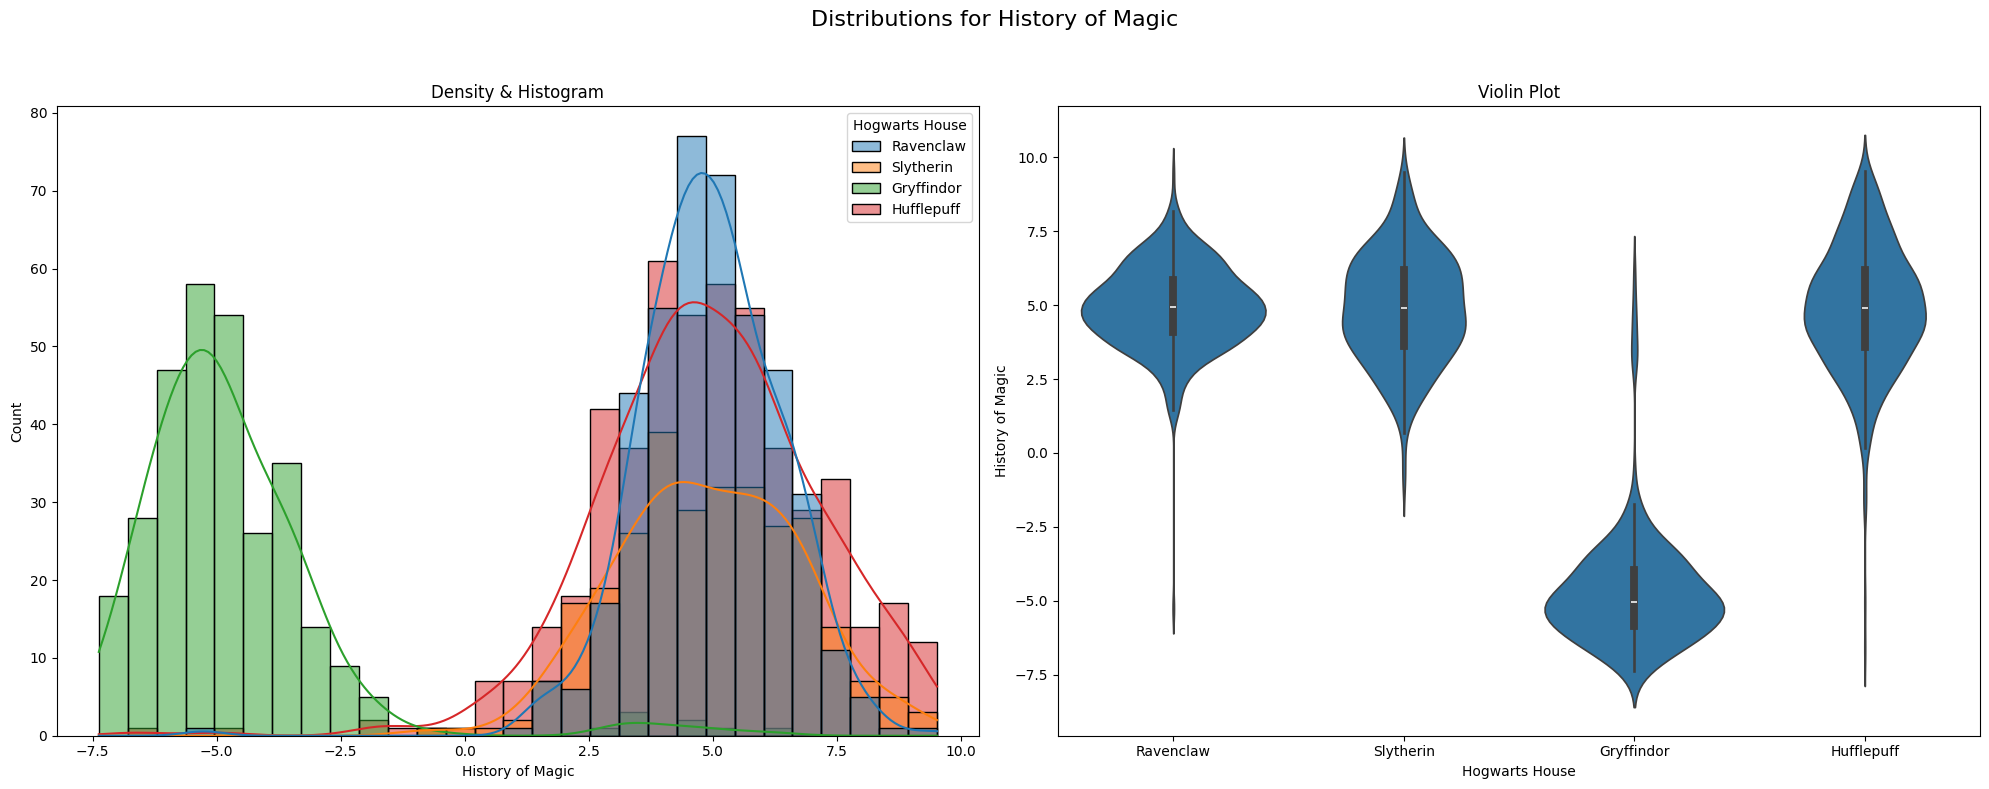

In [21]:
plot_continuous_distribution(train_df, "History of Magic",hue="Hogwarts House", plots=["distplot", "violin"])

### Transfiguration (Very Interesting)

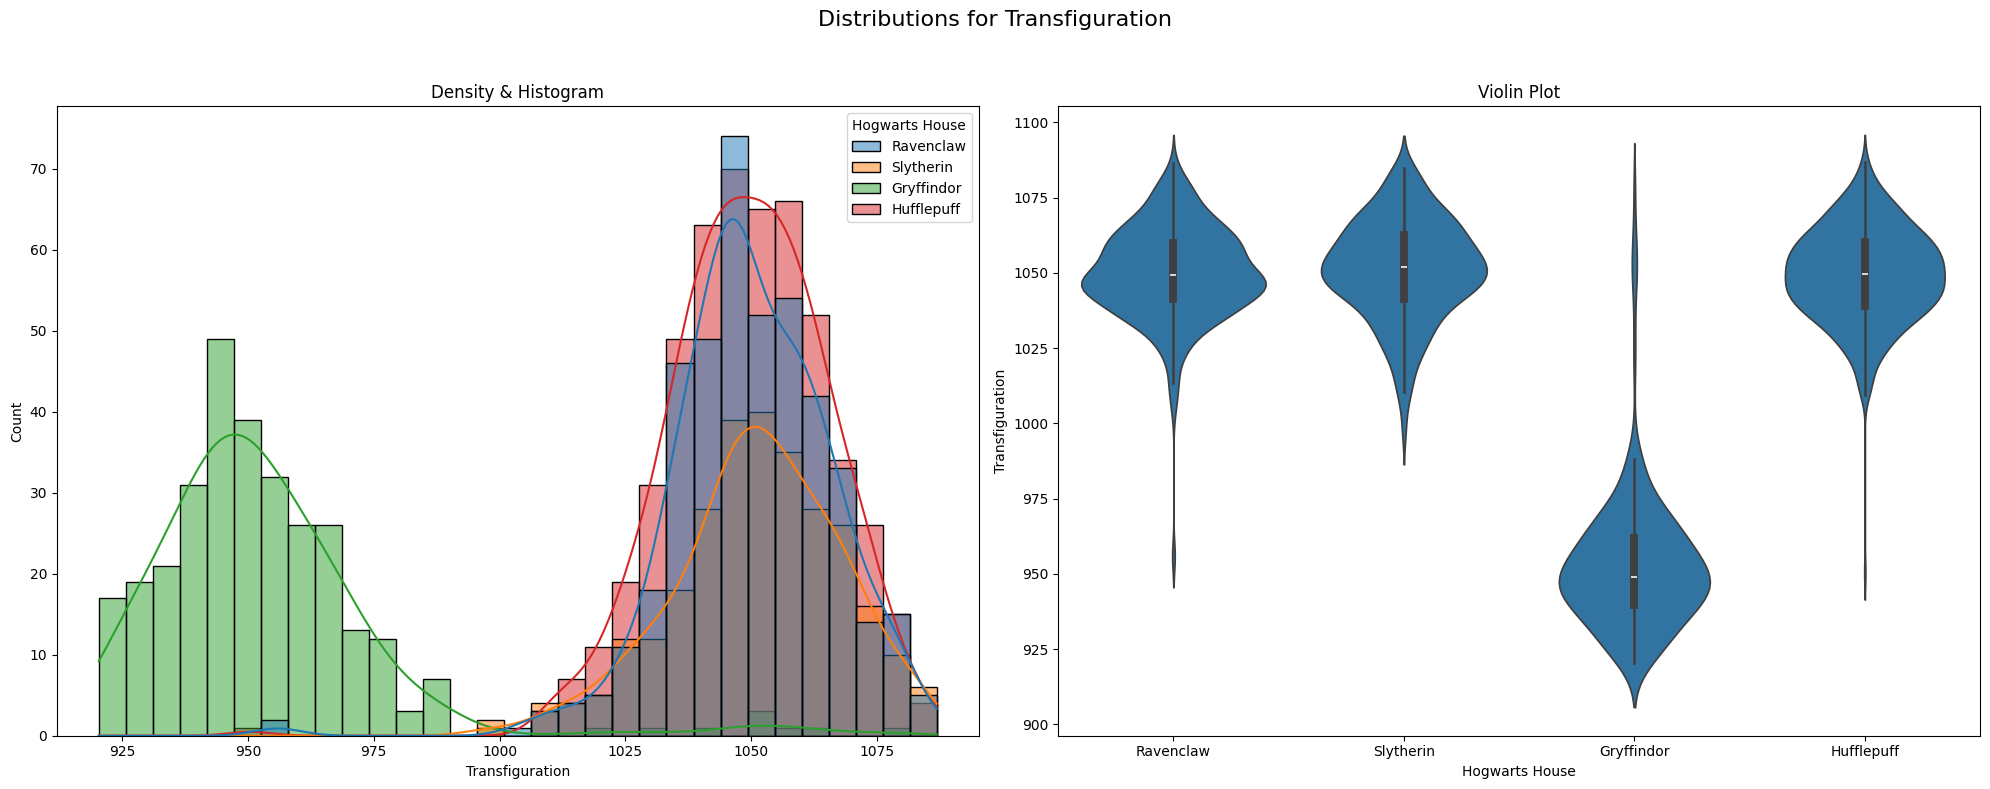

In [22]:
plot_continuous_distribution(train_df, "Transfiguration",hue="Hogwarts House", plots=["distplot", "violin"])

### Potions (Somewhat Interesting)

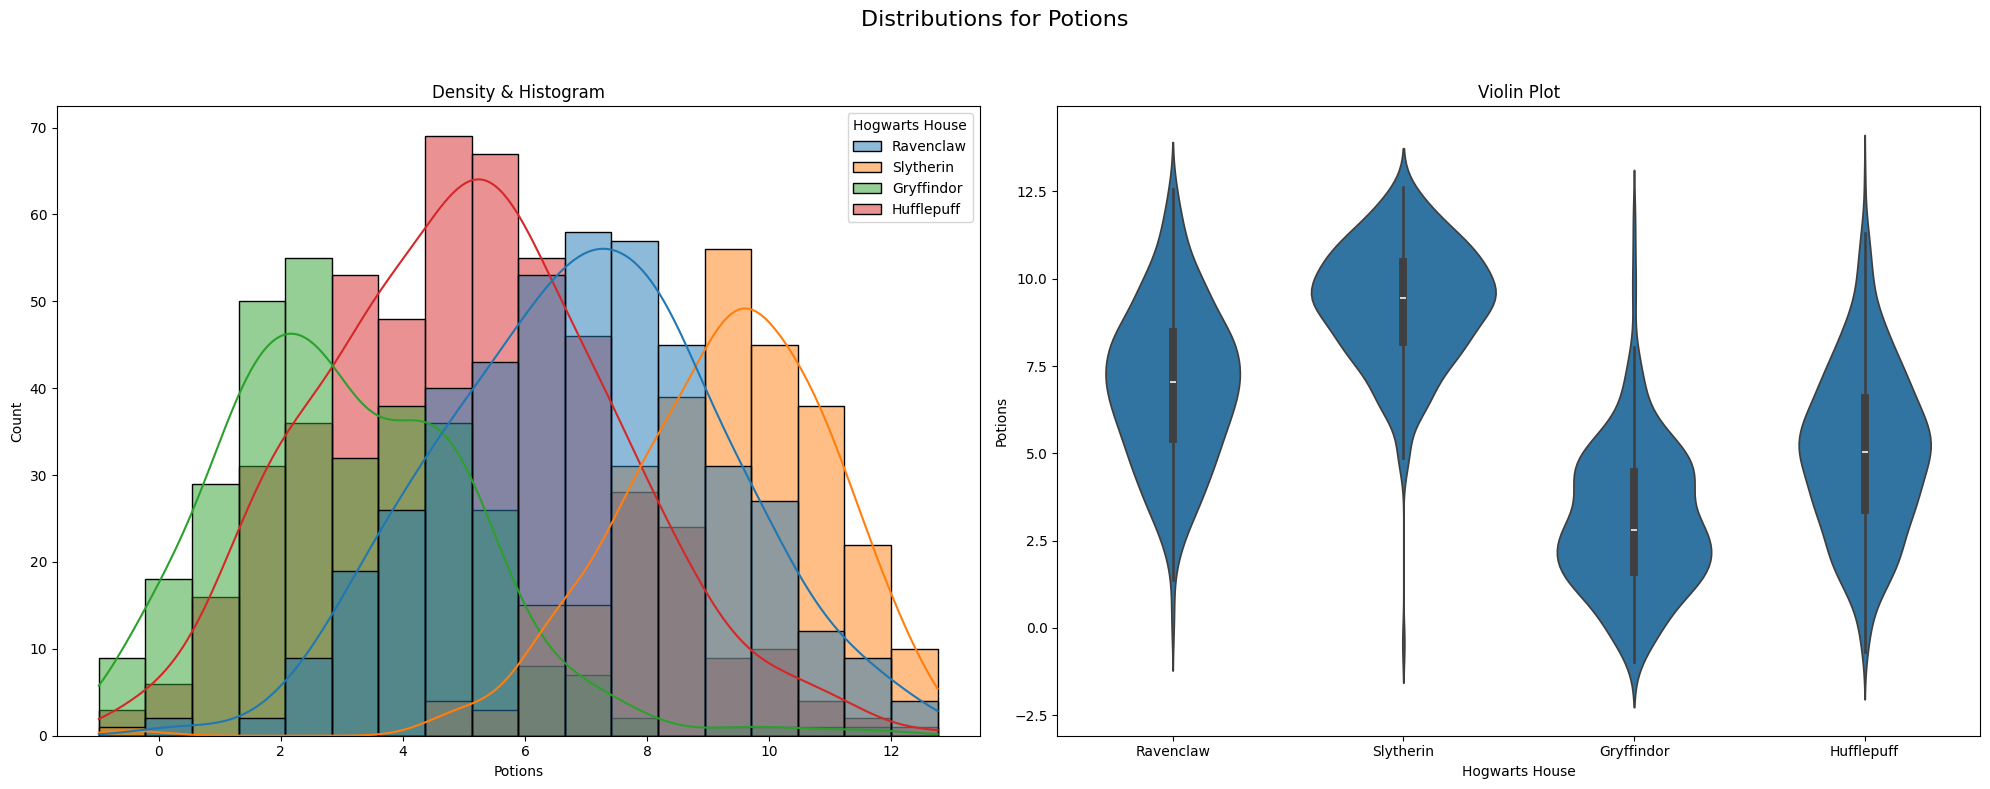

In [23]:
plot_continuous_distribution(train_df, "Potions",hue="Hogwarts House", plots=["distplot", "violin"])

### Care of Magical Creatures (Not interesting)

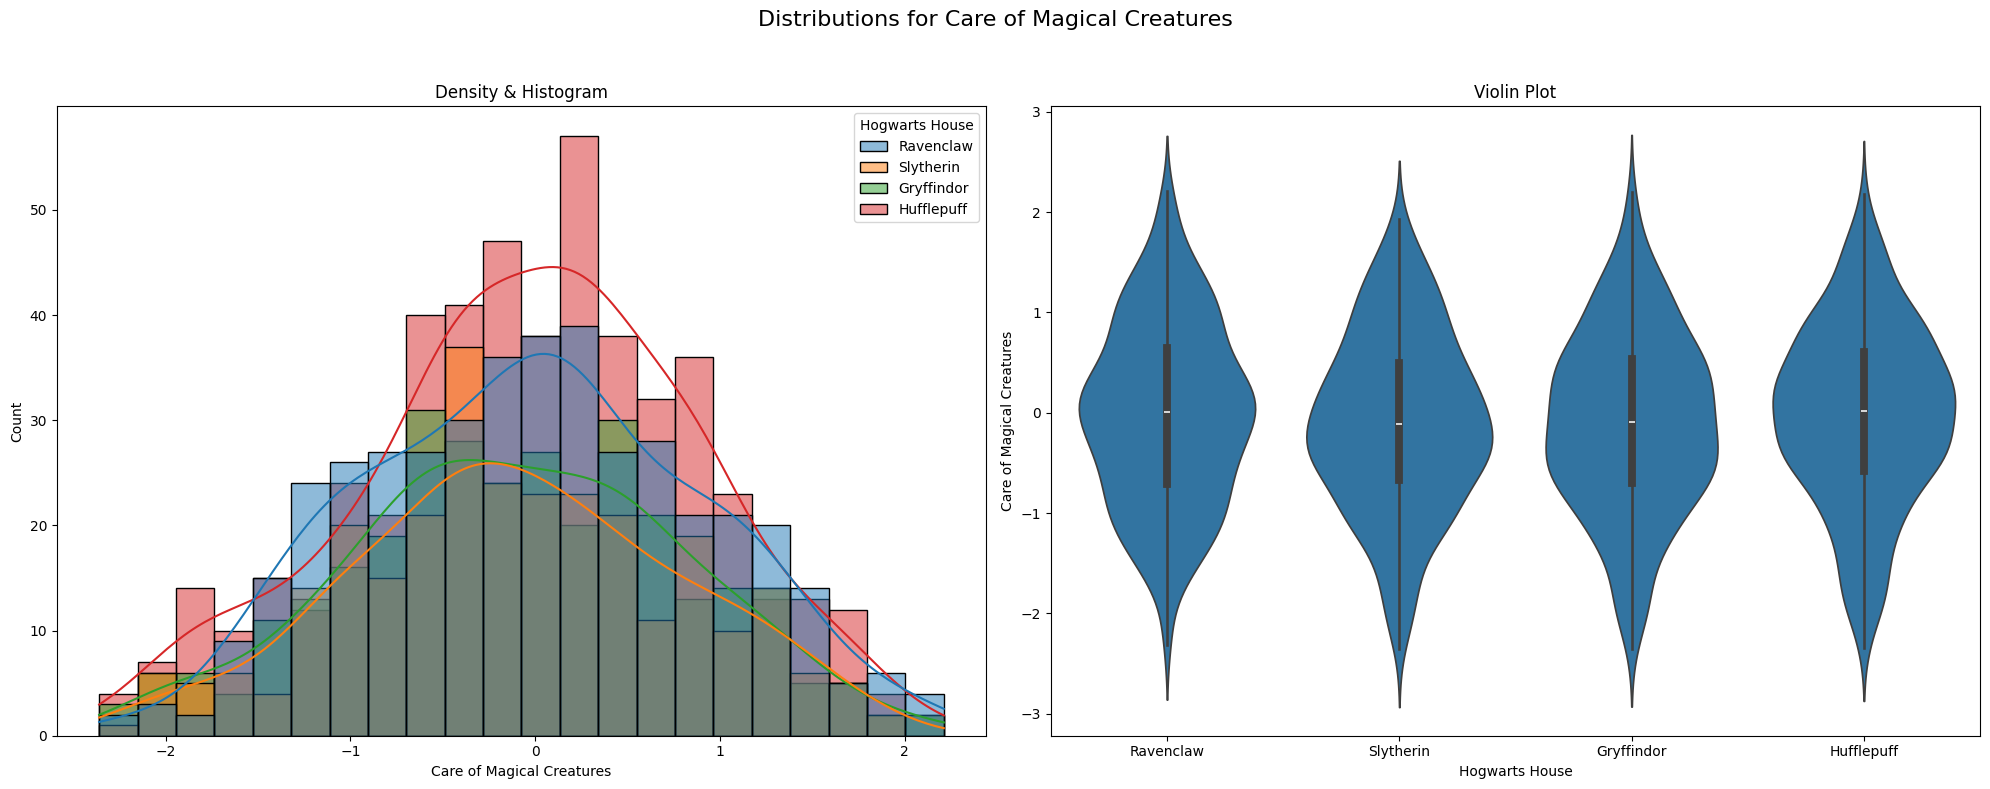

In [24]:
plot_continuous_distribution(train_df, "Care of Magical Creatures",hue="Hogwarts House", plots=["distplot", "violin"])

### Charms (Very Interesting)

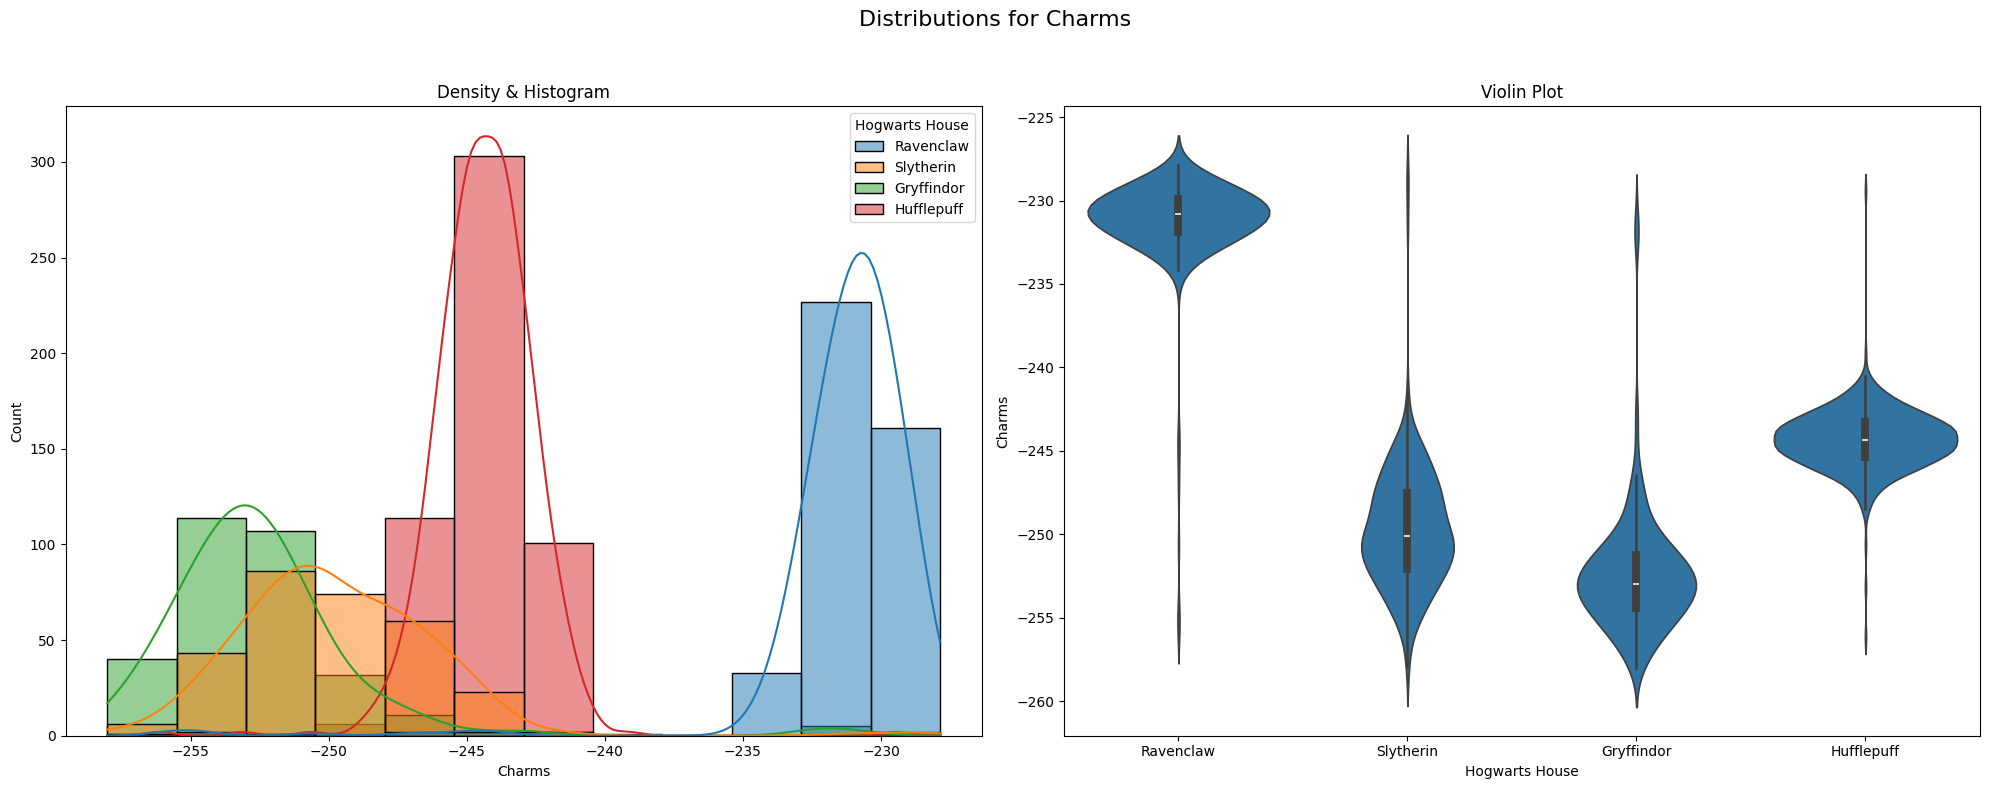

In [25]:
plot_continuous_distribution(train_df, "Charms",hue="Hogwarts House", plots=["distplot", "violin"])

### Flying (Very Interesting)

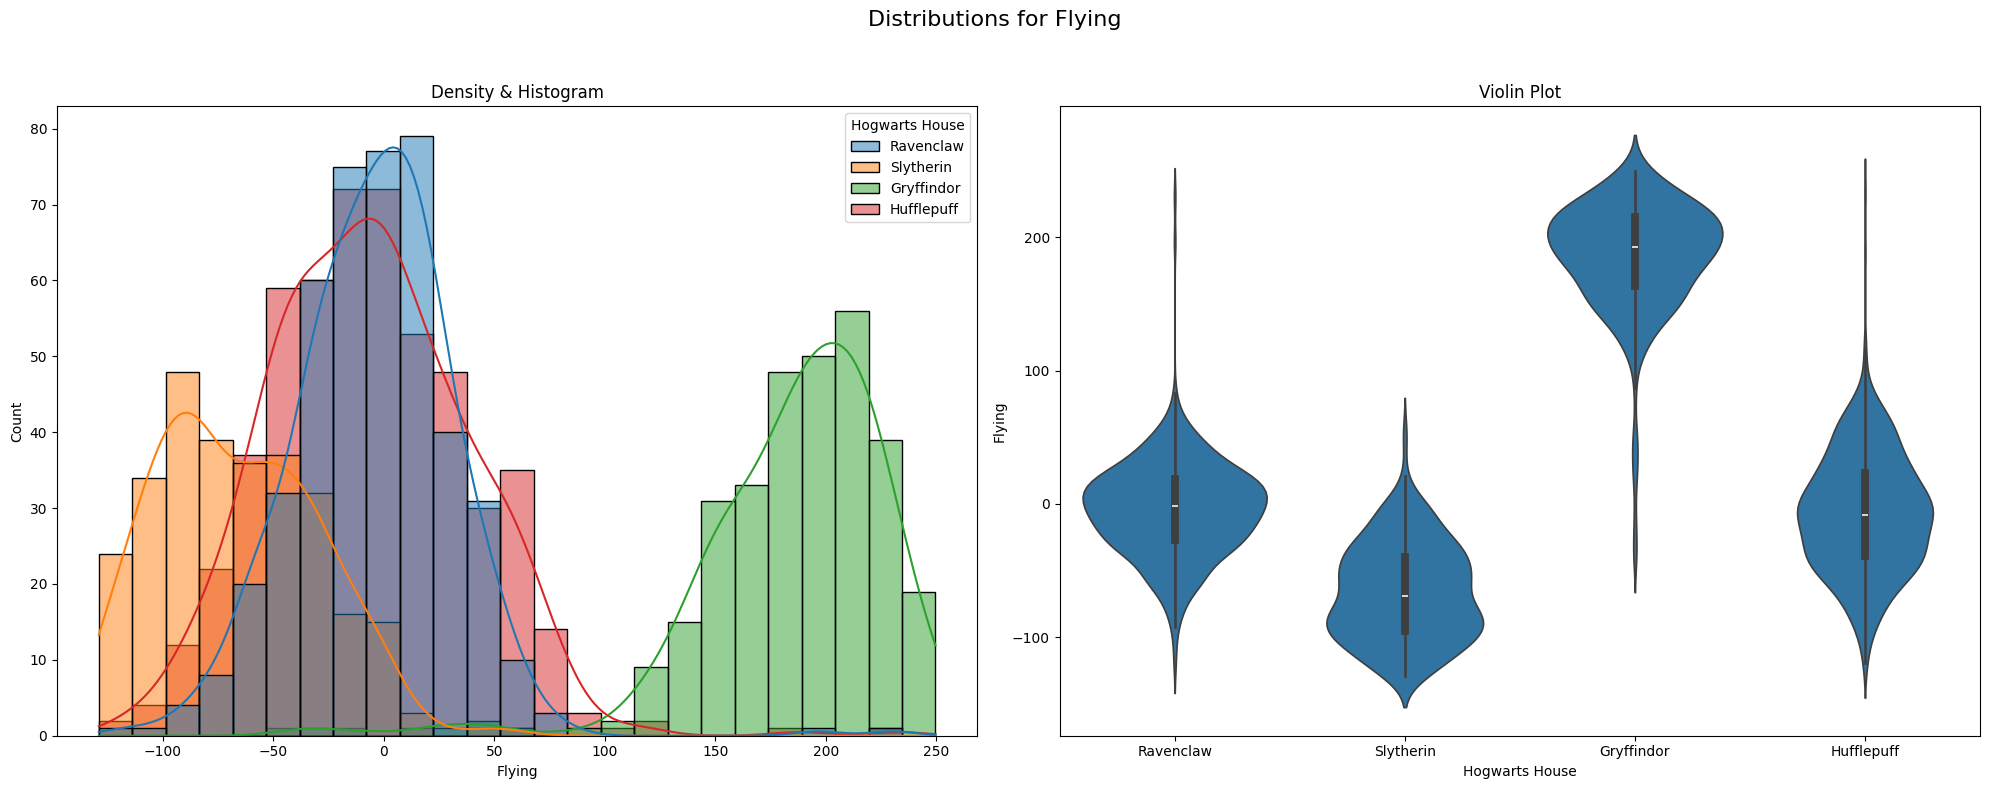

In [26]:
plot_continuous_distribution(train_df, "Flying",hue="Hogwarts House", plots=["distplot", "violin"])

## Preprocessing

Let's drop all features that are not good predictors (separators) for Houses

In [27]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

TO_DROP = ["Index", "First Name", "Last Name", "Best Hand", "Birthday", "Year of Birth" ]

train_df = train_df.drop(columns=TO_DROP, errors='ignore')

X_train = train_df.drop("Hogwarts House", axis=1)
y_train = train_df["Hogwarts House"]

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

#Impute missing values
means = X_train.mean()
X_train = X_train.fillna(means)


### Correlation Map

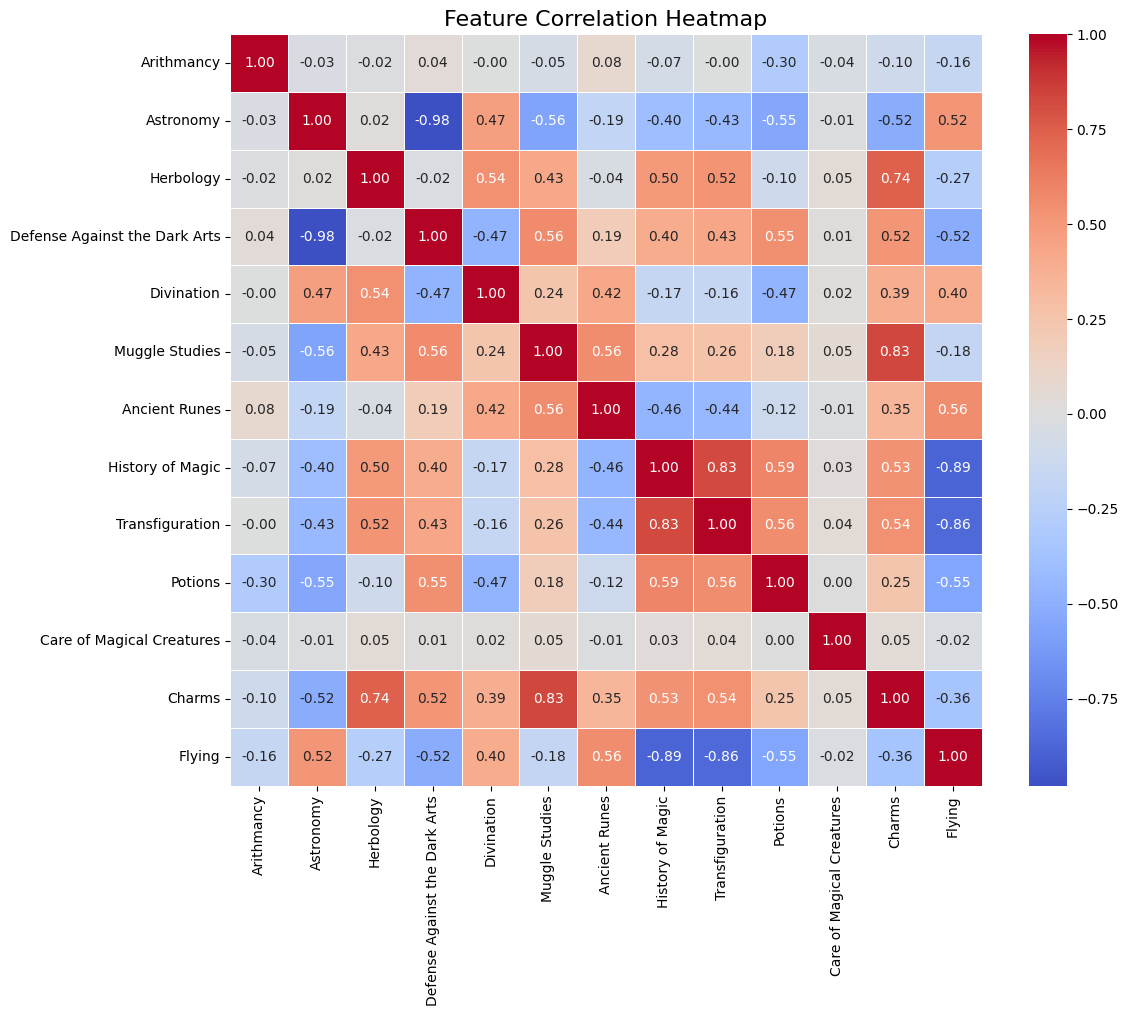

In [28]:
corr = X_train.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",         # format to 2 decimal places
    cmap="coolwarm",   # diverging color map
    center=0,          # center the colormap at zero
    square=True,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_elimination(X, k=1, thresh=None, verbose=True):
    """
    Iteratively drop the variable with highest VIF.
    """
    X = X.dropna().copy()
    history = []

    for i in range(k):
        # Compute VIFs
        vif = pd.Series(
            [variance_inflation_factor(X.values, idx)
             for idx in range(X.shape[1])],
            index=X.columns
        )
        
        # Optionally stop if below threshold
        if thresh is not None and vif.max() <= thresh:
            if verbose:
                print(f"All VIFs ≤ {thresh:.2f}; stopping early at iteration {i}.")
            break
        
        # Identify and drop the worst offender
        worst_feature = vif.idxmax()
        worst_vif     = vif.max()
        history.append((worst_feature, worst_vif))
        
        if verbose:
            print(f"Iteration {i+1}: dropping '{worst_feature}' (VIF = {worst_vif:.2f})")
        
        X = X.drop(columns=[worst_feature])
    
    history_df = pd.DataFrame(history, columns=['dropped_feature', 'VIF'])
    return X, history_df


X_train_reduced, _ = vif_elimination(X_train, k=10, thresh=10)

Iteration 1: dropping 'Transfiguration' (VIF = 6756.28)
Iteration 2: dropping 'Ancient Runes' (VIF = 598.24)
Iteration 3: dropping 'Charms' (VIF = 44.59)
Iteration 4: dropping 'Defense Against the Dark Arts' (VIF = 25.22)
Iteration 5: dropping 'History of Magic' (VIF = 16.51)
All VIFs ≤ 10.00; stopping early at iteration 5.


### Correlation Map (After Variable Elimination)

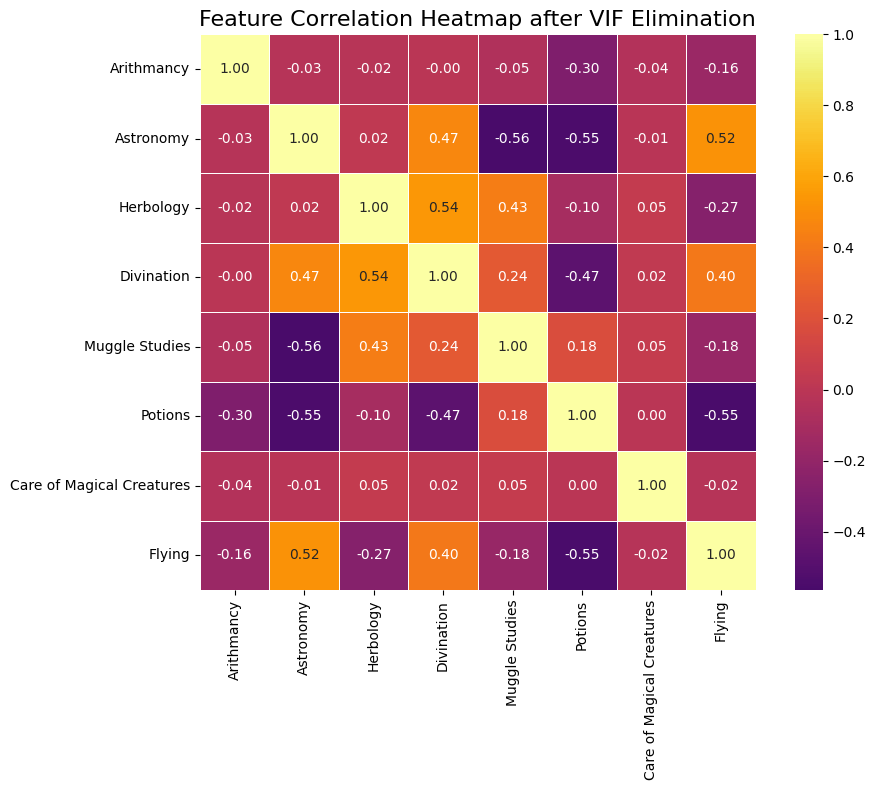

In [33]:
corr = X_train_reduced.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,        # show correlation values
    fmt=".2f",         # format to 2 decimal places
    cmap="inferno",   # diverging color map
    center=0,          # center the colormap at zero
    square=True,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap after VIF Elimination", fontsize=16)
plt.tight_layout()
plt.show()

## Training

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score


scaler = StandardScaler()

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)


clf = LogisticRegression(
    penalty="l2",
    max_iter=10000
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(
    clf,
    X_train_reduced_scaled,
    y_train_encoded,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f"CV accuracies: {scores}")
print(f"Mean CV accuracy: {scores.mean():.5f} ± {scores.std():.3f} | Interval = [{scores.mean() - scores.std():.5f}, {scores.mean() + scores.std()}]")

CV accuracies: [0.98125  0.984375 0.98125  0.984375 0.978125]
Mean CV accuracy: 0.98187 ± 0.002 | Interval = [0.97954, 0.9842135358667337]
